In [1]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats

from itertools import combinations
from sklearn.linear_model import LinearRegression

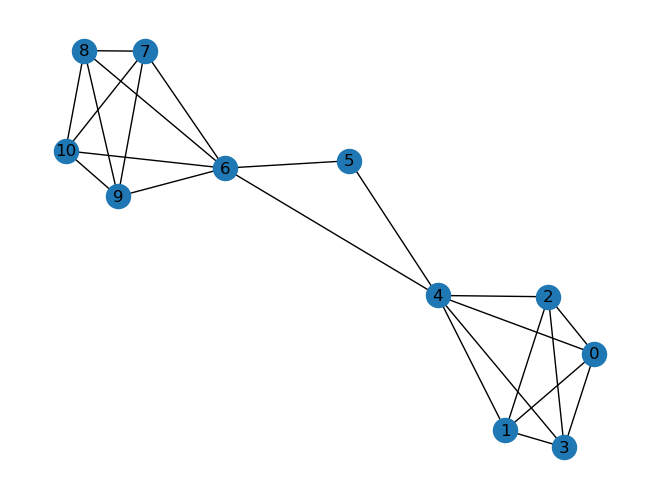

In [2]:
G = nx.barbell_graph(5, 1) 
G.add_edges_from([(4,6)])
pos = nx.spring_layout(G, seed=19302)
nx.draw(G, pos, with_labels=True)
plt.show()

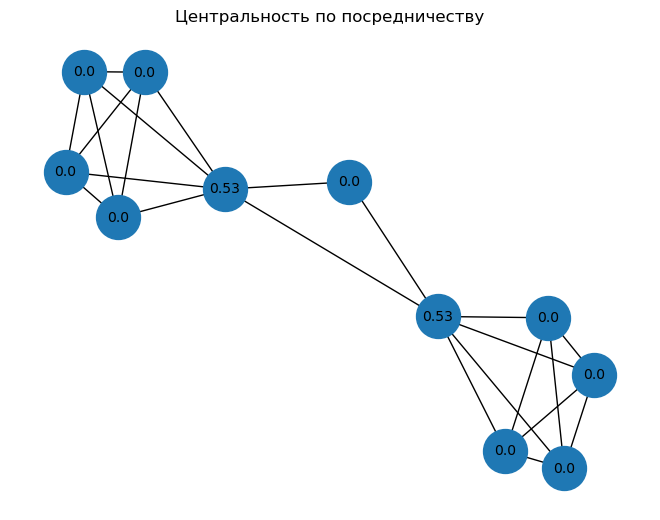

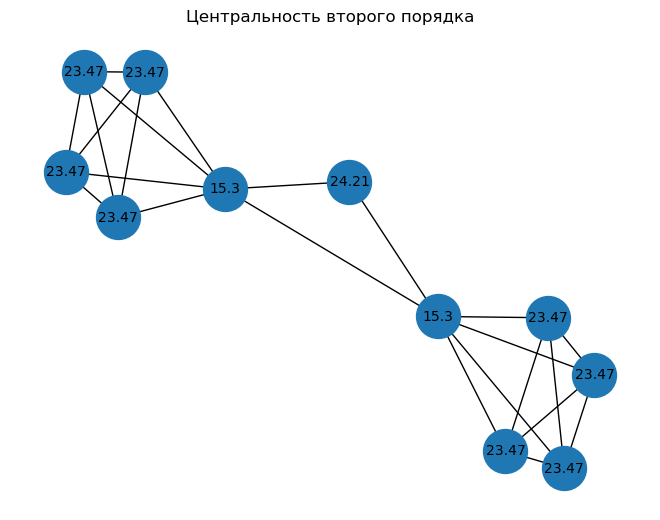

In [3]:
bc = nx.betweenness_centrality(G) 
soc = nx.second_order_centrality(G) 

for key in bc.keys():
    bc[key] = round(bc[key],2)
    soc[key] = round(soc[key],2)


nx.draw(G, pos, with_labels=True, labels=bc, font_size=10, node_size = 10**3)
plt.title("Центральность по посредничеству")
plt.show()

nx.draw(G, pos, with_labels=True, labels=soc, font_size=10, node_size = 10**3)
plt.title("Центральность второго порядка")
plt.show()

Task 2

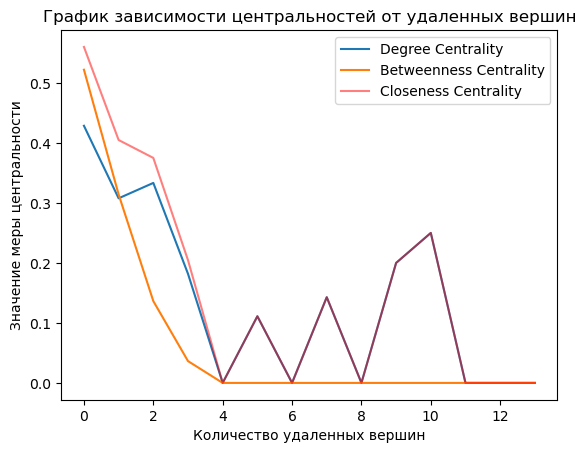

In [4]:
degree_centrality = nx.degree_centrality(G) 
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

G = nx.florentine_families_graph()

degree_values = [] 
betweenness_values = []
closeness_values = []
H = G.copy()
while H.number_of_nodes() > 1:
    
    betweenness_centrality = nx.betweenness_centrality(H) 
    closeness_centrality = nx.closeness_centrality(H)
    degree_centrality = nx.degree_centrality(H)
    
    max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get) 
    
    degree_values.append(degree_centrality[max_betweenness_node]) 
    betweenness_values.append(betweenness_centrality[max_betweenness_node])
    closeness_values.append(closeness_centrality[max_betweenness_node])

    H.remove_node(max_betweenness_node)
    
plt.plot(degree_values, label='Degree Centrality')
plt.plot(betweenness_values, label='Betweenness Centrality')
plt.plot(closeness_values, label='Closeness Centrality', alpha = 0.5, color = 'red')

plt.xlabel('Количество удаленных вершин')
plt.ylabel('Значение меры центральности')
plt.title('График зависимости центральностей от удаленных вершин')
plt.legend()
plt.show()

Task 3

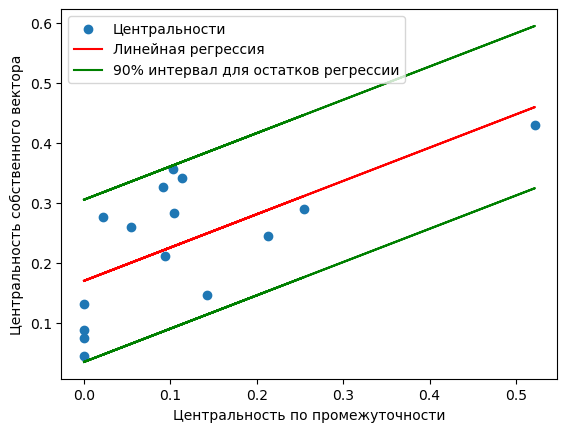

90% интервал для остатков регрессии: (-0.13527531911834373, 0.13527531911834356)
Важные вершины графа: ['Medici', 'Castellani', 'Peruzzi', 'Strozzi', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Bischeri', 'Guadagni']
Gatekeeper вершины: ['Medici', 'Albizzi', 'Salviati', 'Guadagni']


In [5]:
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

x = np.array(list(betweenness_centrality.values()))
x = x.reshape(-1, 1)
y = np.array(list(eigenvector_centrality.values()))
lr = LinearRegression()
lr.fit(x, y)
regression_line = lr.predict(x)


upper_bound = [max(regression_line), max(regression_line)]
lower_bound = [-max(regression_line), -max(regression_line)]

# Вычисление остатков регрессии
residuals = y - regression_line
residuals_mean = np.mean(residuals)
residuals_std = np.std(residuals)
confidence_interval = stats.norm.interval(0.9, loc=residuals_mean, scale=residuals_std)

# Построение графика
plt.scatter(x, y, label='Центральности')
plt.plot(x, regression_line, color='r', label='Линейная регрессия')
plt.xlabel('Центральность по промежуточности')
plt.ylabel('Центральность собственного вектора')
# plt.plot(confidence_interval, upper_bound, lower_bound, alpha=0.5, label='90% интервал для остатков регрессионной модели')
plt.plot(x, [r + confidence_interval[0] for r in regression_line], color='g', label='90% интервал для остатков регрессии')
plt.plot(x, [r + confidence_interval[1] for r in regression_line], color='g')
plt.legend()
plt.show()


print("90% интервал для остатков регрессии:", confidence_interval)

# Определение наиболее важных вершин графа
important_states = [node for node, centrality in eigenvector_centrality.items() if centrality > np.mean(list(eigenvector_centrality.values()))]
gate_keeper = [node for node, centrality in betweenness_centrality.items() if centrality > np.mean(list(betweenness_centrality.values()))]

print("Важные вершины графа:", important_states)
print("Gatekeeper вершины:", gate_keeper)


Task 4

In [6]:
G = nx.Graph([ 
    (1, 8, {'weight': 8}), 
    (2, 1, {'weight': 3}),
    (3, 1, {'weight': 5}),
    (3, 4, {'weight': 5}),
    (3, 5, {'weight': 1}),
    (4, 3, {'weight': 6}),
    (3, 6, {'weight': 7}),
    (4, 7, {'weight': 1}),
    (5, 2, {'weight': 6}),
    (7, 1, {'weight': 7}),
    (7, 2, {'weight': 4}),
    (7, 5, {'weight': 8}),
    (7, 8, {'weight': 3}),
    (8, 2, {'weight': 3}),
    (8, 6, {'weight': 9}),
    (9, 6, {'weight': 4}),
    (10, 6, {'weight': 1})
])

In [7]:
G_nodes = range(1, len(G.nodes))
n_factorial = math.factorial(len(G_nodes))
shapley_values = {i: 0 for i in G_nodes}

for node in G_nodes:
    S_without_node = set(G_nodes) - {node} 
    for num_of_subnodes in range(2, len(S_without_node)): # перебор комбинаций подмножеств вершин S_without_node
        s_factorial = math.factorial(num_of_subnodes - 1) # (s-1)!
        n_s_factorial = math.factorial(len(G_nodes) - num_of_subnodes) # (s-n)!

        for combination in combinations(S_without_node, num_of_subnodes):
            S_v = nx.group_degree_centrality(G, combination)
            additional_value = 1 - S_v # (c(S) - c(S\{v}))
            shapley_values[node] += s_factorial * n_s_factorial * additional_value
            
    shapley_values[node] = shapley_values[node]/n_factorial

custom_values = {i: 0 for i in G_nodes} # ранжирование вершин 
for node in G_nodes:
    c_d = nx.degree_centrality(G)[node]
    c_b = nx.betweenness_centrality(G)[node]
    c_e = nx.eccentricity(G)[node]
    c_c = nx.closeness_centrality(G)[node]
    c_so = nx.second_order_centrality(G)[node] / 100
    c_ei = nx.eigenvector_centrality(G)[node]
    custom_values[node] = (c_d + c_b + c_e - c_so - c_ei) / 10

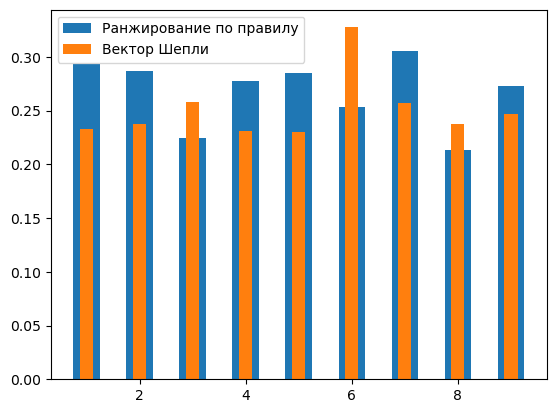

In [8]:
plt.bar(custom_values.keys(), custom_values.values(), width=0.5, label='Ранжирование по правилу')
plt.bar(shapley_values.keys(), shapley_values.values(), width=0.25, label='Вектор Шепли')
plt.legend()